<h1 align="center" style="font-family:Times New Roman;"> 
    <b> CSE4/510: Reinforcement Learning</b><br>
<b>Summer 2020</b><br>
<b>Instructor: Alina Vereshchaka </b><br>
<b>Project 2 </b>
</h1>


---

<h2 align="right">By:<br>
    Samratsinh Sudhirsinh Dhumal<br>
    50321053<br>
    samratsi@buffalo.edu<br>
</h2>

### Importing Libraries

In [1]:
%matplotlib inline
import gym
import matplotlib.pyplot as plt
import numpy as np
import keras
import random
from collections import deque
import time
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


### Information of the Environment

In [2]:
env = gym.make('CartPole-v0')
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)
env.reset()

Observation space: Box(4,)
Action space: Discrete(2)


array([-0.0142657 ,  0.01326979, -0.02504476, -0.01222676])

In [3]:
for _ in range(5):
    action = env.action_space.sample()
    print('action', action)
    observation, reward, done, info = env.step(action)
    print(observation, reward, done, info)
    if done:
        break
env.close()

action 1
[-0.0140003   0.2087418  -0.0252893  -0.31270521] 1.0 False {}
action 0
[-0.00982546  0.01398908 -0.0315434  -0.0281038 ] 1.0 False {}
action 0
[-0.00954568 -0.18066665 -0.03210548  0.25446233] 1.0 False {}
action 1
[-0.01315902  0.01489865 -0.02701623 -0.04817184] 1.0 False {}
action 1
[-0.01286104  0.21039736 -0.02797967 -0.34925471] 1.0 False {}


### Convolution layers used

In [4]:
model = Sequential()
model.add(Dense(10, activation='relu', input_shape = (4, )))
model.add(Dense(2, activation='softmax'))

In [5]:
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adadelta(learning_rate=1),
             metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                50        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 22        
Total params: 72
Trainable params: 72
Non-trainable params: 0
_________________________________________________________________


## DQN

### Defining Experience

In [6]:
class ReplayMemory:

    def __init__(self):
        self.memory = deque()

    def stored_memory(self, state, action, reward, next_state, done):
        self.memory.append({'state': state, 'action': action, 'reward': reward, 'next_state': next_state, 'done': done})
        return self.memory

### Defining Neural Network

In [7]:
class NeuralNetwork:

    def __init__(self, gamma, alpha):
        self.gamma = gamma
        self.alpha = alpha
        self.init_nn_model()        

    def init_nn_model(self):

        self.nn_model = Sequential()
        self.nn_model.add(Dense(10, activation='relu', input_shape = (4, )))
        self.nn_model.add(Dense(2, activation='softmax'))
        self.nn_model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adadelta(learning_rate=self.alpha),
             metrics=['accuracy'])


    def train_nn_model(self, s_mem, states, y_trains): 

        if len(s_mem) == 2:
            qval = s_mem[-2]['reward'] + self.gamma * np.max(self.q_value_pre(s_mem[-2]['next_state']))
            y_train = self.q_value_pre(s_mem[-2]['state'])
            y_train[0][s_mem[-2]['action']] = qval
            y_trains[-1] = y_train.reshape(2)

        states.append(s_mem[-1]['state'])
        qval = s_mem[-1]['reward']
        y_train = self.q_value_pre(s_mem[-1]['state'])
        y_train[0][s_mem[-1]['action']] = qval
        y_trains.append(y_train.reshape(2))
        self.nn_model.fit(np.array(states), np.array(y_trains), batch_size = 128, verbose=0)
        _, accuracy = self.nn_model.evaluate(np.array(states), np.array(y_trains), verbose=0)
        return states, y_trains, accuracy


    def q_value_pre(self, state):
        state = state.reshape(1, 4)
        return self.nn_model.predict(state)

### Defining Agent

In [8]:
class DQN_Agent():

    def __init__(self, env, eps_start, eps_decay, eps_min):
        self.env = env
        self.eps_start = max([eps_start * eps_decay, eps_min])

    def greedy_action(self, state, neuralnetwork):

        if np.random.uniform() < self.eps_start:
            return np.random.choice(2)
        else:
            value = np.argmax(neuralnetwork.q_value_pre(state))
        return value

### Training the algorithm on the environment

In [9]:
dqn_agent = DQN_Agent(env, eps_start=1.0, eps_decay=0.99999, eps_min=0.0001)
neuralnetwork = NeuralNetwork(alpha=0.01, gamma=0.99999)
rmemory = ReplayMemory()

states = []
y_trains = []
f_acc = []
total_reward = 0
avg_reward = []

episodes = 1000
for episode in range(episodes):
    state = env.reset()
    done = False
    counter = 0
    while not done:
        action = dqn_agent.greedy_action(state, neuralnetwork)
        next_state, reward, done, _ = env.step(action)
        if done:
            reward = -reward
        s_mem = rmemory.stored_memory(state, action, reward, next_state, done)
        states, y_trains, f_acc = neuralnetwork.train_nn_model(s_mem, states, y_trains)
        np.copyto(state, next_state)
        counter +=1
    percent_acc = round(f_acc*100, 2)
    total_reward += counter
    avg_reward.append(total_reward/(episode+1))
    print("Episode: " + str(episode+1) + ", Accuracy: " + str(percent_acc) + " %  Average Reward: " + str(round(avg_reward[-1], 2)))

Episode: 1, Accuracy: 42.11 %  Average Reward: 19.0
Episode: 2, Accuracy: 36.67 %  Average Reward: 15.0
Episode: 3, Accuracy: 40.82 %  Average Reward: 16.33
Episode: 4, Accuracy: 38.71 %  Average Reward: 15.5
Episode: 5, Accuracy: 44.34 %  Average Reward: 21.2
Episode: 6, Accuracy: 43.85 %  Average Reward: 21.67
Episode: 7, Accuracy: 43.59 %  Average Reward: 22.29
Episode: 8, Accuracy: 42.17 %  Average Reward: 20.75
Episode: 9, Accuracy: 43.17 %  Average Reward: 20.33
Episode: 10, Accuracy: 42.34 %  Average Reward: 22.2
Episode: 11, Accuracy: 44.03 %  Average Reward: 22.09
Episode: 12, Accuracy: 45.63 %  Average Reward: 21.0
Episode: 13, Accuracy: 46.52 %  Average Reward: 21.0
Episode: 14, Accuracy: 48.98 %  Average Reward: 21.0
Episode: 15, Accuracy: 48.22 %  Average Reward: 20.6
Episode: 16, Accuracy: 49.38 %  Average Reward: 20.12
Episode: 17, Accuracy: 49.56 %  Average Reward: 20.18
Episode: 18, Accuracy: 48.54 %  Average Reward: 22.89
Episode: 19, Accuracy: 48.84 %  Average Reward

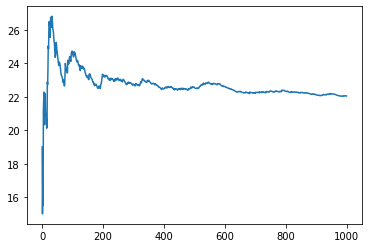

In [10]:
plt.plot(avg_reward)

### Testing the algorithm

In [11]:
dqn_agent.eps_start = 0
dqn_agent.eps_min = 0

states = []
y_trains = []
test_f_acc = []
test_total_reward = 0
test_avg_reward = []

episodes = 100
for episode in range(episodes):
    state = env.reset()
    done = False
    counter = 0
    while not done:
        action = dqn_agent.greedy_action(state, neuralnetwork)
        next_state, _, done, _ = env.step(action)
        np.copyto(state, next_state)
        counter += 1
    test_total_reward += counter
    test_avg_reward.append(test_total_reward/(episode+1))
    print("Episode: " + str(episode+1) + ",  Average Reward: " + str(round(test_avg_reward[-1], 2)))

Episode: 1,  Average Reward: 10.0
Episode: 2,  Average Reward: 10.5
Episode: 3,  Average Reward: 11.0
Episode: 4,  Average Reward: 11.0
Episode: 5,  Average Reward: 10.6
Episode: 6,  Average Reward: 10.5
Episode: 7,  Average Reward: 10.43
Episode: 8,  Average Reward: 10.25
Episode: 9,  Average Reward: 10.11
Episode: 10,  Average Reward: 10.1
Episode: 11,  Average Reward: 10.18
Episode: 12,  Average Reward: 10.25
Episode: 13,  Average Reward: 10.31
Episode: 14,  Average Reward: 10.29
Episode: 15,  Average Reward: 10.27
Episode: 16,  Average Reward: 10.19
Episode: 17,  Average Reward: 10.24
Episode: 18,  Average Reward: 10.22
Episode: 19,  Average Reward: 10.21
Episode: 20,  Average Reward: 10.2
Episode: 21,  Average Reward: 10.1
Episode: 22,  Average Reward: 10.05
Episode: 23,  Average Reward: 10.04
Episode: 24,  Average Reward: 10.17
Episode: 25,  Average Reward: 10.24
Episode: 26,  Average Reward: 10.27
Episode: 27,  Average Reward: 10.26
Episode: 28,  Average Reward: 10.25
Episode: 2

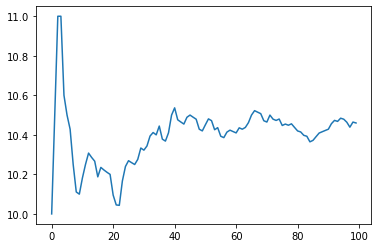

In [12]:
 plt.plot(test_avg_reward)

## Double DQN

### Defining Experience

In [13]:
class Double_ReplayMemory:

    def __init__(self):
        self.memory = deque()

    def stored_memory(self, state, action, reward, next_state, done):
        self.memory.append({'state': state, 'action': action, 'reward': reward, 'next_state': next_state, 'done': done})
        return self.memory

### Defining Neural Networks

In [14]:
class Double_NeuralNetwork:

    def __init__(self, gamma, alpha):
        self.gamma = gamma
        self.alpha = alpha
        self.init_nn_model()        

    def init_nn_model(self):

        self.nn_model_one = Sequential()
        self.nn_model_one.add(Dense(10, activation='relu', input_shape = (4, )))
        self.nn_model_one.add(Dense(2, activation='softmax'))
        self.nn_model_one.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adadelta(learning_rate=self.alpha),
             metrics=['accuracy'])
        
        self.nn_model_two = Sequential()
        self.nn_model_two.add(Dense(10, activation='relu', input_shape = (4, )))
        self.nn_model_two.add(Dense(2, activation='softmax'))
        self.nn_model_two.set_weights(self.nn_model_one.get_weights())


    def train_nn_model(self, s_mem, states, y_trains): 
        qval = 0
        if len(s_mem) == 2:

            qval += s_mem[-2]['reward'] + self.gamma * self.q_value_two(s_mem[-2]['next_state'])[0][np.argmax(self.q_value_one(s_mem[-2]['next_state']))]

            y_train = self.q_value_one(s_mem[-2]['state'])
            y_train[0][s_mem[-2]['action']] = qval
            y_trains[-1] = y_train.reshape(2)

        states.append(s_mem[-1]['state'])
        qval = s_mem[-1]['reward']
        y_train = self.q_value_one(s_mem[-1]['state'])
        y_train[0][s_mem[-1]['action']] = qval
        y_trains.append(y_train.reshape(2))
        self.nn_model_one.fit(np.array(states), np.array(y_trains), batch_size = 128, verbose=0)
        _, accuracy = self.nn_model_one.evaluate(np.array(states), np.array(y_trains), verbose=0)
        return states, y_trains, accuracy


    def q_value_one(self, state):
        state = state.reshape(1, 4)
        return self.nn_model_one.predict(state)

    def q_value_two(self, state):
        state = state.reshape(1, 4)
        return self.nn_model_two.predict(state)


### Defining Agent

In [15]:
class Double_DQN_Agent():

    def __init__(self, env, eps_start, eps_decay, eps_min):
        self.env = env
        self.eps_start = max([eps_start * eps_decay, eps_min])

    def greedy_action(self, state, neuralnetwork):

        if np.random.uniform() < self.eps_start:
            return np.random.choice(2)
        else:
            value = np.argmax(neuralnetwork.q_value_one(state))
        return value

### Training the algorithm on the environment

In [16]:
d_dqn_agent = Double_DQN_Agent(env, eps_start=1.0, eps_decay=0.9, eps_min=0.1)
d_neuralnetwork = Double_NeuralNetwork(alpha=0.1, gamma=0.9)
d_rmemory = Double_ReplayMemory()

d_states = []
y_trains = []
f_acc = []
total_reward = 0
avg_reward = []
count = 0

episodes = 750
for episode in range(episodes):
    state = env.reset()
    done = False
    counter = 0
    while not done:
        action = d_dqn_agent.greedy_action(state, d_neuralnetwork)
        next_state, reward, done, _ = env.step(action)
        if done:
            reward = -reward
        s_mem = d_rmemory.stored_memory(state, action, reward, next_state, done)
        d_states, y_trains, f_acc = d_neuralnetwork.train_nn_model(s_mem, d_states, y_trains)
        np.copyto(state, next_state)
        counter +=1
        count += 1
        if count % 10 == 0:
            d_neuralnetwork.nn_model_two.set_weights(d_neuralnetwork.nn_model_one.get_weights())
    percent_acc = round(f_acc*100, 2)
    total_reward += counter
    avg_reward.append(total_reward/(episode+1))
    print("Episode: " + str(episode+1) + ", Accuracy: " + str(percent_acc) + " %  Average Reward: " + str(round(avg_reward[-1], 2)))

Episode: 1, Accuracy: 75.0 %  Average Reward: 12.0
Episode: 2, Accuracy: 60.0 %  Average Reward: 25.0
Episode: 3, Accuracy: 61.9 %  Average Reward: 21.0
Episode: 4, Accuracy: 59.3 %  Average Reward: 21.5
Episode: 5, Accuracy: 58.65 %  Average Reward: 20.8
Episode: 6, Accuracy: 57.58 %  Average Reward: 22.0
Episode: 7, Accuracy: 57.32 %  Average Reward: 23.43
Episode: 8, Accuracy: 55.93 %  Average Reward: 22.12
Episode: 9, Accuracy: 56.41 %  Average Reward: 21.67
Episode: 10, Accuracy: 55.13 %  Average Reward: 23.4
Episode: 11, Accuracy: 53.26 %  Average Reward: 23.73
Episode: 12, Accuracy: 51.47 %  Average Reward: 22.67
Episode: 13, Accuracy: 51.32 %  Average Reward: 23.23
Episode: 14, Accuracy: 50.47 %  Average Reward: 22.64
Episode: 15, Accuracy: 48.66 %  Average Reward: 22.47
Episode: 16, Accuracy: 48.01 %  Average Reward: 22.0
Episode: 17, Accuracy: 48.24 %  Average Reward: 23.41
Episode: 18, Accuracy: 48.5 %  Average Reward: 24.06
Episode: 19, Accuracy: 48.0 %  Average Reward: 23.

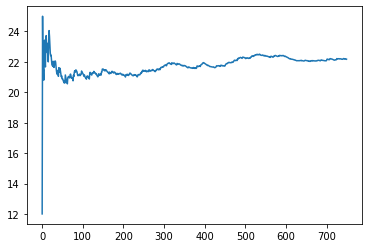

In [17]:
plt.plot(avg_reward)

### Testing the algorithm

In [18]:
d_dqn_agent.eps_start = 0
d_dqn_agent.eps_min = 0

states = []
y_trains = []
test_f_acc = []
test_total_reward = 0
test_avg_reward = []

episodes = 75
for episode in range(episodes):
    state = env.reset()
    done = False
    counter = 0
    while not done:
        action = d_dqn_agent.greedy_action(state, d_neuralnetwork)
        next_state, _, done, _ = env.step(action)
        np.copyto(state, next_state)
        counter += 1
    test_total_reward += counter
    test_avg_reward.append(test_total_reward/(episode+1))
    print("Episode: " + str(episode+1) + ",  Average Reward: " + str(round(test_avg_reward[-1], 2)))

Episode: 1,  Average Reward: 9.0
Episode: 2,  Average Reward: 9.5
Episode: 3,  Average Reward: 9.33
Episode: 4,  Average Reward: 9.25
Episode: 5,  Average Reward: 9.4
Episode: 6,  Average Reward: 9.5
Episode: 7,  Average Reward: 9.57
Episode: 8,  Average Reward: 9.5
Episode: 9,  Average Reward: 9.44
Episode: 10,  Average Reward: 9.5
Episode: 11,  Average Reward: 9.55
Episode: 12,  Average Reward: 9.5
Episode: 13,  Average Reward: 9.54
Episode: 14,  Average Reward: 9.5
Episode: 15,  Average Reward: 9.53
Episode: 16,  Average Reward: 9.56
Episode: 17,  Average Reward: 9.59
Episode: 18,  Average Reward: 9.61
Episode: 19,  Average Reward: 9.63
Episode: 20,  Average Reward: 9.6
Episode: 21,  Average Reward: 9.57
Episode: 22,  Average Reward: 9.55
Episode: 23,  Average Reward: 9.52
Episode: 24,  Average Reward: 9.5
Episode: 25,  Average Reward: 9.52
Episode: 26,  Average Reward: 9.5
Episode: 27,  Average Reward: 9.52
Episode: 28,  Average Reward: 9.54
Episode: 29,  Average Reward: 9.55
Episo

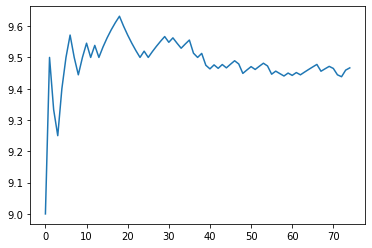

In [19]:
plt.plot(test_avg_reward)